# Vessel extraction: test script
## Import modules

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import black_tophat, disk, remove_small_objects, remove_small_holes, skeletonize

## Load pictures

In [5]:
data_path = "./data/"
image_list = os.listdir(data_path)
img_file = image_list[0]
print(f"Processing image: {img_file}")

Processing image: img2512221726-1.tif


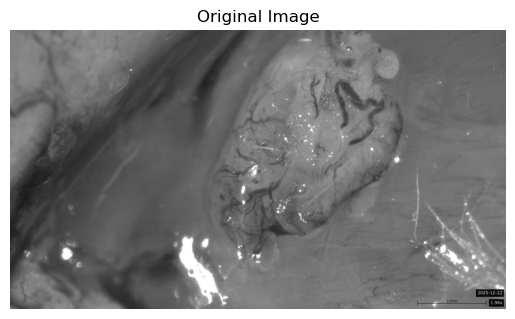

In [6]:
img_path = os.path.join(data_path, img_file)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Display the original image in grayscale
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

## Writing functions for image processing

In [7]:
# Convert RGB to Vessel Contrast Channel
def extract_vessel_channel(img):
    if img.ndim == 3:
        # Use green channel (strongest Hb contrast)
        green = img[:,:,1]
        return green
    else:
        return img

In [8]:
# Enhance dark structures (vessels) using contrast normalization and inversion
def enhance_dark_structures(img):
    img = img.astype(np.float32)
    
    # Contrast normalization
    img = (img - img.min()) / (img.max() - img.min())
    
    # Invert → dark vessels become bright
    inverted = 1 - img
    
    # Slight Gaussian smoothing
    inverted = cv2.GaussianBlur(inverted, (5,5), 0)
    
    return inverted

In [9]:
# Top-Hat Filtering (Enhance Thin Dark Lines)
def dark_tophat_enhancement(img, radius=8):
    selem = disk(radius)
    enhanced = black_tophat(img, selem)
    return enhanced

In [10]:
# Thresholding (Otsu's method)
def threshold_image(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary

In [17]:
# Cleanup
def clean_binary(binary, max_size=200, hole_max_size=100):
    binary = remove_small_objects(binary, max_size=max_size)    
    binary = remove_small_holes(binary, max_size=hole_max_size)
    return binary

In [12]:
# Skeletonization
def get_skeleton(binary):
    return skeletonize(binary)

## Run the pipeline

In [18]:
# Step 1: channel extraction
vessel_channel = extract_vessel_channel(img)

# Step 2: invert + normalize
inverted = enhance_dark_structures(vessel_channel)

# Step 3: optional black top-hat
enhanced = dark_tophat_enhancement(inverted, radius=10)

# Step 4: threshold
binary = threshold_image(enhanced)

# Step 5: cleanup
# pass the desired object size threshold using the new keyword
clean = clean_binary(binary, max_size=300)

# Step 6: skeleton
skel = get_skeleton(clean)

## Visualization

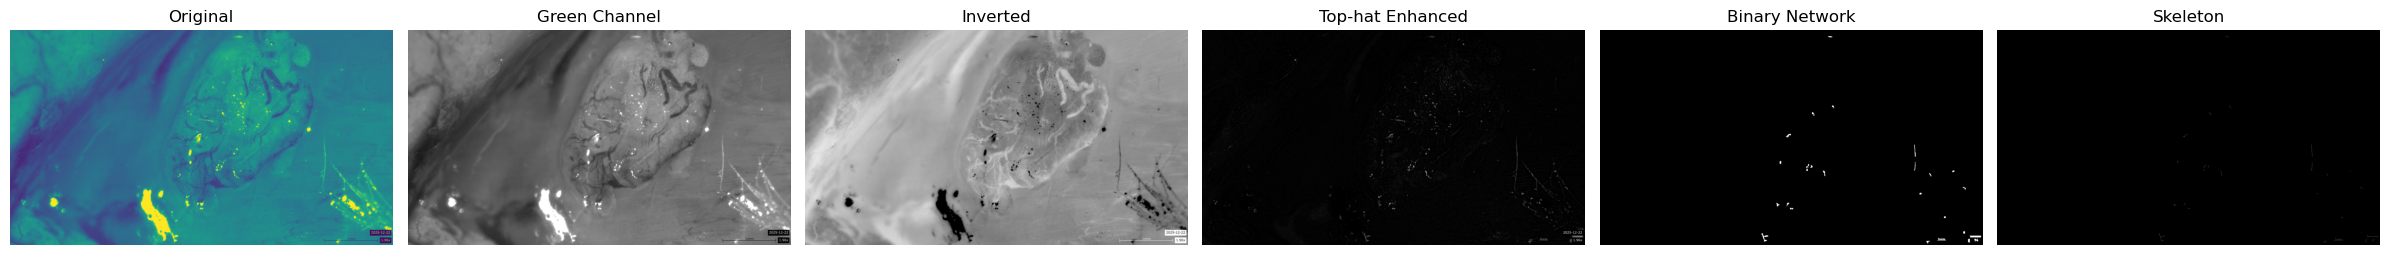

In [21]:
fig, axes = plt.subplots(1,6, figsize=(24,4))

axes[0].imshow(img)
axes[0].set_title("Original")

axes[1].imshow(vessel_channel, cmap="gray")
axes[1].set_title("Green Channel")

axes[2].imshow(inverted, cmap="gray")
axes[2].set_title("Inverted")

axes[3].imshow(enhanced, cmap="gray")
axes[3].set_title("Top-hat Enhanced")

axes[4].imshow(clean, cmap="gray")
axes[4].set_title("Binary Network")

axes[5].imshow(skel, cmap="gray")
axes[5].set_title("Skeleton")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()